# **Part 2a**

### 1. Data Loading and Creating label encoder for each column

#### a. Loading

In [1]:
# import necessary libraries 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm

# Ignore all warnings
warnings.filterwarnings("ignore")

2023-10-04 21:02:59.100663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
df = pd.read_csv('a_BRFSS_original_classes.csv')

In [3]:
df.head()

,Age,Sex,Race,Education,Income,Smoking_status,Alcohol_consumption,BMI,General_health,Physical_health,Mental_health,Hypertension,High_cholesterol,Diabetes_status
0,65 or older,Female,White,High School Graduate,$25000 - $34999,No,No,Underweight,Poor,Yes,Yes,No,Yes,No Diabetes
1,65 or older,Female,Black,High School Graduate,$15000 - $24999,No,No,Overweight,Very Good,No,No,Yes,No,Diabetes
2,55 - 64,Female,White,High School Graduate,$50000 - $99999,No,Yes,Obese,Very Good,No,Yes,Yes,Yes,Diabetes
3,65 or older,Male,Other,< High School,$15000 - $24999,No,No,Overweight,Poor,Yes,No,No,Yes,Diabetes
4,65 or older,Male,White,Some College,$35000 - $49999,No,No,Normal Weight,Good,No,No,No,No,No Diabetes


#### b. LabelEncoder

In [4]:
# Create a LabelEncoder for each column with nominal values
label_encoders = {}

for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

In [5]:
df.head()

,Age,Sex,Race,Education,Income,Smoking_status,Alcohol_consumption,BMI,General_health,Physical_health,Mental_health,Hypertension,High_cholesterol,Diabetes_status
0,5,0,5,2,2,0,0,3,3,1,1,0,1,1
1,5,0,2,2,1,0,0,2,4,0,0,1,0,0
2,4,0,5,2,4,0,1,1,4,0,1,1,1,0
3,5,1,4,0,1,0,0,2,3,1,0,0,1,0
4,5,1,5,3,3,0,0,0,2,0,0,0,0,1


### 2. Data Preprocessing:


#### a. Separating the features and the target variable


In [6]:
# Feature matrix X and target vector y
X = df.drop(['Diabetes_status'], axis=1)
y = df['Diabetes_status']


#### b. Splitting the dataset

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (204783, 13) (204783,)
Test set shape: (51196, 13) (51196,)


#### c. Handling imbalanced data 

In [8]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution before SMOTE:
Diabetes_status
1    174366
0     30417
Name: count, dtype: int64
Class distribution after SMOTE:
Diabetes_status
1    174366
0    174366
Name: count, dtype: int64


#### d. Feature Importance: Random Forests

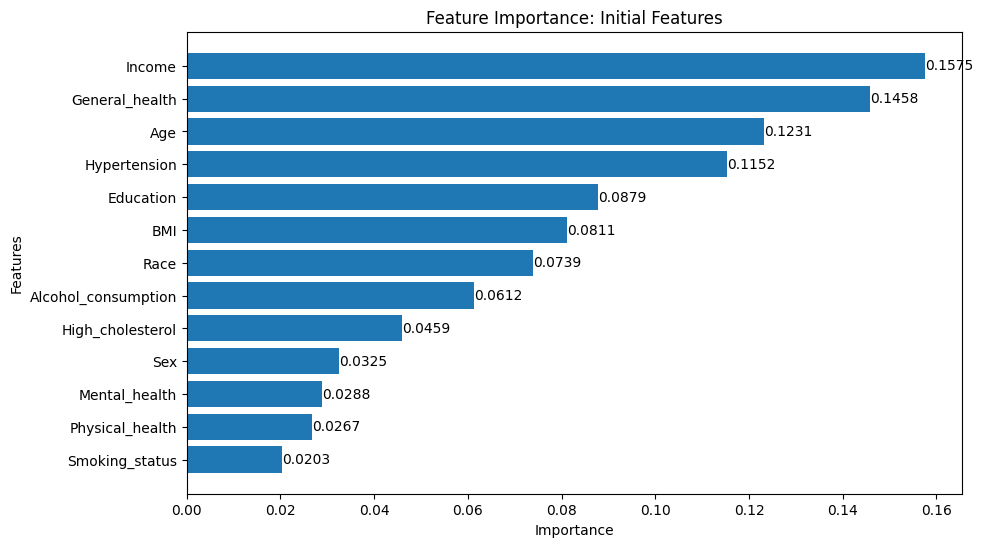

In [9]:

# Create and fit the Random Forest classifier using the resampled training data
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Access feature importances
importances = model.feature_importances_

# Sort importances in descending order
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_features = X.columns[sorted_indices]

# Create a vertically oriented bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Initial Features')

# Add values to the bars
for i, v in enumerate(sorted_importances):
    plt.text(v, i, format(v, '.4f'), color='black', va='center')

plt.show()


### 2. Model Training and Evaluation:


Comparing classification algorithms, logistic regression, Random Forest and Sequencial Model. Training the model on the training data and evaluating its performance on the testing data using model:

Logistic Regression:
- Pros: Interpretable, computationally efficient, low risk of overfitting.
- Cons: Limited flexibility, struggles with complex relationships, requires feature engineering.

Random Forest:
- Pros: Excellent predictive performance, handles high-dimensional data, robust to outliers, provides feature importance.
- Cons: Less interpretable, computationally expensive, may overfit with noisy data, difficulty handling imbalanced data.

Sequential Models:
- Pros: Captures temporal dependencies, handles complex relationships, automatic feature learning, potential for high accuracy.
- Cons: Computationally expensive, requires large amounts of data, difficult to interpret, risk of overfitting.

The choice of evaluation metrics for diabetes prevention models is crucial to assess the model's performance and determine its effectiveness in achieving the desired goal. The following following metrics were used: 

- Accuracy: Measures overall correct predictions. It's useful for classifying individuals as at risk or not. However, it may be insufficient for imbalanced datasets.

- ROC AUC: Assesses the model's ability to discriminate between positive and negative instances across probability thresholds. It evaluates the model's ranking and differentiation of at-risk individuals from others.

- Recall: Measures the proportion of correctly identified positive instances. It captures the model's ability to minimize false negatives and identify individuals at risk for diabetes.

- Precision: Measures the proportion of correctly predicted positive instances. It focuses on minimizing false positives, avoiding unnecessary interventions.
- Specificity: Measures the proportion of correctly identified negative instances. It captures the model's ability to minimize false positives and identify individuals who are not at risk for diabetes.

These metrics are commonly used in binary classification tasks, such as predicting the risk of diabetes. They provide different perspectives on the performance of a predictive model and help evaluate its effectiveness in identifying individuals at risk for the condition. It's important to consider these metrics together to have a comprehensive understanding of the model's strengths and weaknesses.



#### a. Model Training


In [10]:
# Fit a logistic regression model and make predictions
lr = LogisticRegression()  # Initialize a logistic regression classifier
lr.fit(X_train_resampled, y_train_resampled)  # Train the model using the scaled training data
lr_predictions = lr.predict(X_test)  # Generate predictions on the test data

In [11]:
# Random Forest Classifier
rf = RandomForestClassifier()  # Initialize a random forest classifier
rf.fit(X_train_resampled, y_train_resampled)  # Train the model using the scaled training data
rf_predictions = rf.predict(X_test)  # Generate predictions on the test data

In [12]:
# Deep Learning Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64)
dl_predictions = model.predict(X_test)

Epoch 1/10
5449/5449 [==============================] - 11s 2ms/step - loss: 0.5245 - accuracy: 0.7387
Epoch 2/10
5449/5449 [==============================] - 10s 2ms/step - loss: 0.5145 - accuracy: 0.7455
Epoch 3/10
5449/5449 [==============================] - 10s 2ms/step - loss: 0.5116 - accuracy: 0.7474
Epoch 4/10
5449/5449 [==============================] - 9s 2ms/step - loss: 0.5093 - accuracy: 0.7485
Epoch 5/10
5449/5449 [==============================] - 9s 2ms/step - loss: 0.5072 - accuracy: 0.7497
Epoch 6/10
5449/5449 [==============================] - 10s 2ms/step - loss: 0.5056 - accuracy: 0.7505
Epoch 7/10
5449/5449 [==============================] - 10s 2ms/step - loss: 0.5037 - accuracy: 0.7520
Epoch 8/10
5449/5449 [==============================] - 9s 2ms/step - loss: 0.5023 - accuracy: 0.7528
Epoch 9/10
5449/5449 [==============================] - 7s 1ms/step - loss: 0.5007 - accuracy: 0.7536
Epoch 10/10
1600/1600 [==============================] - 2s 893us/step


In [13]:
# Convert predictions to binary values
dl_predictions = (dl_predictions > 0.5).astype(int)

### 3. Model Evaluation

#### a. Model Evaluation

In [14]:
# For Logistic Regression model
tn, fp, fn, tp = confusion_matrix(y_test, lr_predictions).ravel()
specificity_lr = tn / (tn + fp)  # Specificity calculation

# For Random Forest model
tn, fp, fn, tp = confusion_matrix(y_test, rf_predictions).ravel()
specificity_rf = tn / (tn + fp)  # Specificity calculation

# For Deep Learning model
tn, fp, fn, tp = confusion_matrix(y_test, dl_predictions).ravel()
specificity_dl = tn / (tn + fp)  # Specificity calculation

In [15]:
# Print model metrics values
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("ROC AUC:", roc_auc_score(y_test, lr_predictions))
print("Recall:", recall_score(y_test, lr_predictions))
print("Precision:", precision_score(y_test, lr_predictions))
print("Specificity:", specificity_lr)

print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("ROC AUC:", roc_auc_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Specificity:", specificity_rf)

print("\nDeep Learning Model Metrics:")
dl_predictions = dl_predictions.flatten()
print("Accuracy:", accuracy_score(y_test, dl_predictions))
print("ROC AUC:", roc_auc_score(y_test, dl_predictions))
print("Recall:", recall_score(y_test, dl_predictions))
print("Precision:", precision_score(y_test, dl_predictions))
print("Specificity:", specificity_dl)


Logistic Regression Metrics:
Accuracy: 0.6966169231971248
ROC AUC: 0.7109418662977982
Recall: 0.6905111835759886
Precision: 0.9360291370937617
Specificity: 0.7313725490196078

Random Forest Metrics:
Accuracy: 0.7442768966325494
ROC AUC: 0.6612131773207147
Recall: 0.7796812566022138
Precision: 0.9065954606141522
Specificity: 0.5427450980392157

Deep Learning Model Metrics:
Accuracy: 0.725115243378389
ROC AUC: 0.736637908856955
Recall: 0.7202039222890736
Precision: 0.9431896785059096
Specificity: 0.7530718954248365


These metrics provide an evaluation of the performance of each model. Logistic Regression achieved an accuracy of 0.6966, with a slightly higher ROC AUC of 0.7109. The model also had a recall of 0.6905 and high precision of 0.9360. The specificity was 0.7314.

The Random Forest model performed better in terms of accuracy with a score of 0.7443. However, its ROC AUC was lower at 0.6612. It had a higher recall of 0.7797 and a slightly lower precision of 0.9066. The specificity was 0.5427.

The Deep Learning Model had an accuracy of 0.7251 and a higher ROC AUC of 0.7366. It had a recall of 0.7202 and a precision of 0.9432, indicating good performance. The specificity was 0.7531.

These results suggest that the logistic regression model had the highest precision and the deep learning model had the highest ROC AUC. The random forest model had the highest accuracy but lower precision and ROC AUC compared to the other models. 

### 4. Model Comparison Plot

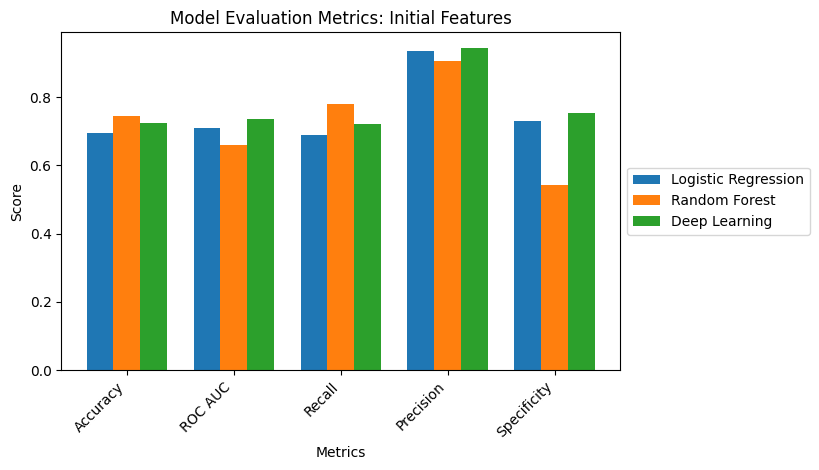

In [16]:
# Create dictionaries for model metrics
lr_metrics = {
    "Accuracy": accuracy_score(y_test, lr_predictions),
    "ROC AUC": roc_auc_score(y_test, lr_predictions),
    "Recall": recall_score(y_test, lr_predictions),
    "Precision": precision_score(y_test, lr_predictions),
    "Specificity": specificity_lr,
}

rf_metrics = {
    "Accuracy": accuracy_score(y_test, rf_predictions),
    "ROC AUC": roc_auc_score(y_test, rf_predictions),
    "Recall": recall_score(y_test, rf_predictions),
    "Precision": precision_score(y_test, rf_predictions),
    "Specificity": specificity_rf,
}

dl_metrics = {
    "Accuracy": accuracy_score(y_test, dl_predictions),
    "ROC AUC": roc_auc_score(y_test, dl_predictions),
    "Recall": recall_score(y_test, dl_predictions),
    "Precision": precision_score(y_test, dl_predictions),
    "Specificity": specificity_dl,
}

# Extract metric names and values
metrics = list(lr_metrics.keys())
lr_values = list(lr_metrics.values())
rf_values = list(rf_metrics.values())
dl_values = list(dl_metrics.values())

# Set the width of the bars
bar_width = 0.25
index = np.arange(len(metrics))

# Create bar plots
fig, ax = plt.subplots()
rects1 = ax.bar(index - bar_width, lr_values, bar_width, label='Logistic Regression')
rects2 = ax.bar(index, rf_values, bar_width, label='Random Forest')
rects3 = ax.bar(index + bar_width, dl_values, bar_width, label='Deep Learning')

# Add labels, title, and legend
ax.set_ylabel('Score')
ax.set_xlabel('Metrics')
ax.set_title('Model Evaluation Metrics: Initial Features')
ax.set_xticks(index)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Adjust the layout to prevent labels from being cut off
plt.tight_layout()

# Move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

### 5. Conclusion and Future Work

In this comparative analysis of machine learning models for diabetes prediction, the Deep Learning model emerged as the top performer in terms of accuracay, ROC AUC, precision, and specificity. It demonstrated superior performance in accurately distinguishing individuals with and without diabetes. The Random Forest model showed high recall, making it suitable choice for identifying positive cases. The Logistic Regression model had notable accuracy, ROC AUC, precision, and specificity, making it a runner-up.

These findings highlight the potential of machine learning models in diabetes prediction. However, it is important to consider the specific requirements of the use case and the limitations of the dataset. Further research and model refinement are necessary to enhance the accuracy and robustness of diabetes prediction models.

Furthermore, potential areas for improvement and future work are identified, including collecting more data, exploring alternative algorithms, addressing class imbalance using other methods, feature engineering, hyperparameter tuning, and external validation. These areas provide avenues for enhancing the models' performance and developing more robust predictive models for identifying individuals at risk for diabetes.